# Solution Notebook


In this solution notebook we focus on these key tasks:

1. Loading and visualization of the dataset
2. Running model predictions and evaluating baseline
3. Train model to improve score over this baseline
4. Run evaluations and explain the working of both the given model and trained model


## Table of Contents


1. [Imports](#imports)
2. [Dataset Exploration](#dataset-exploration)

   - [Loading Dataset](#loading-dataset)

3. [Data Plots](#data-plots)

   - [Histogram Plot for Distribution](#histogram-plot-for-distribution)
   - [Visual Image Plot](#visual-image-plot)
   - [PCA Visualizations](#pca-visualizations)
   - [Pixel-Label Correlation Plots](#pixel-label-correlation-plots)

4. [Model Loading](#model-loading)

   - [Running Predictions with the Loaded Model](#running-predictions-with-the-loaded-model)
   - [Finding Optimal Threshold for Provided Model](#finding-optimal-threshold-for-provided-model)

5. [Running Evaluations](#running-evaluations)

   - [Precision-Recall, ROC Curves](#precision-recall-roc-curves)
   - [Classification Report](#classification-report)

6. [Figuring Out What is in the `Lambda`](#figuring-out-what-is-in-the-lambda)
   - [Hypothesis: Lambda Layer Simply Computes a Sum Over the Input Kernel](#hypothesis-lambda-layer-simply-computes-a-sum-over-the-input-kernel)
   - [Verifying Hypothesis by Plotting Model vs Hypothesis Outputs](#verifying-hypothesis-by-plotting-model-vs-hypothesis-outputs)
   - [Explaining Model Outputs](#explaining-model-outputs)


## Imports


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

from collections import Counter

from scripts.dataset_loader import load_dataset
from scripts.exploration_plots import (
    plot_pca_2d,
    plot_pca_3d,
    plot_pixel_label_patterns,
    plot_combined_image,
)
from scripts.model_plots import plot_model_prediction_histogram
from scripts.model_evaluation import (
    find_optimal_threshold,
    plot_confusion_matrix,
    plot_roc_curve,
    plot_precision_recall_curve,
    plot_sample_predictions,
    compare_sum_model_results,
    plot_sum_vs_model_output_plots,
)

NUMPY_SEED_VALUE = 200

## Dataset Exploration


### Loading Dataset


Let's load the dataset as a `tf.data.Dataset` object


In [2]:
dataset, images, labels = load_dataset(batch_size=32)

From here we observe that there are **1000** images of size **16x16**. Each image either has the label as `1` or `0`


In [3]:
print(">> Labels")
print("Shape:", labels.shape)

print("> Unique labels")
print(set(labels))

print("> Single Image Labels")
print(labels[0])
print(labels[800])

print()
print(">> Images")
print("Shape:", images.shape)

print("> Single Image")
print("Shape:", images[0, :, :].shape)
print(images[0, :, :])

>> Labels
Shape: (1000,)
> Unique labels
{0, 1}
> Single Image Labels
0
1

>> Images
Shape: (1000, 16, 16)
> Single Image
Shape: (16, 16)
[[2.1700313  0.3368357  0.5888369  0.6597585  1.138681   0.35873774
  1.8572135  0.83504444 0.18155456 0.7893587  0.9517998  0.02187085
  0.6317337  0.5083703  0.8277021  0.80548126]
 [1.3674951  0.30677652 0.140921   0.14598766 0.16792616 1.6860738
  0.04102432 0.20599899 0.7848744  0.19453607 0.20928012 0.45434618
  0.9031863  0.9356227  0.6061106  2.181677  ]
 [0.0622947  0.52064    0.48904428 1.5958955  0.49071908 2.7082717
  0.06556757 0.2904863  0.2859103  1.0856764  0.05776405 1.1728171
  1.5814979  1.3288999  0.01713689 1.1861597 ]
 [1.2270731  0.08372566 0.8707939  2.5772567  0.07647876 0.48341855
  0.18920054 0.11365169 0.8503427  0.5787239  0.17180316 0.8009488
  0.95969856 0.3596137  0.8661315  0.04501369]
 [0.2039771  2.4431734  0.35061747 1.838147   0.2763531  2.2010422
  0.3528849  0.18543014 0.9194601  1.3772079  0.348033   0.49081576

## Data Plots



### Histrogram plot for distribution



Let's check how this data is distributed. The plot indicates an equitable 50-50 split on the labels!


Label distribution:
Label 0: 500 images
Label 1: 500 images


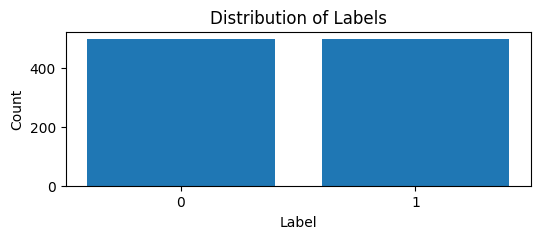

In [4]:
label_counts = Counter(labels)
print("Label distribution:")
for label, count in sorted(label_counts.items()):
    print(f"Label {label}: {count} images")

plt.figure(figsize=(6, 2))
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Labels")
plt.xticks(list(label_counts.keys()))
plt.show()

### Visual Image Plot


- On Visual inspection of the data, The images have distinct visual features. We have this _Signal vs Background_ like dynamic.
- Label 1 shows a concentrated high-energy cluster (signal)
- Label 0 appears more diffused image (background).
- So these could be converted signals of a edge device reading for perturbations, like events when a beam of light or an electron hits the detector. The signal becomes stronger when that event occurs.
- Typically, I would guess these datasets don’t have the balanced 50-50 split seen here, as events are often less likely to occur than the _"nothing happens"_ scenario.


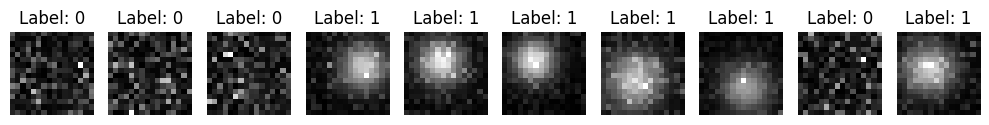

In [5]:
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(images[i], cmap="gray")
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

### PCA Visualizations


- Let's validate our intuition that the two images are easy to distinguish.
- First, we'll flatten each image into a vector and then decompose it into two and three principal component along with their labels.
- We observe again see how well they separate in the plots.


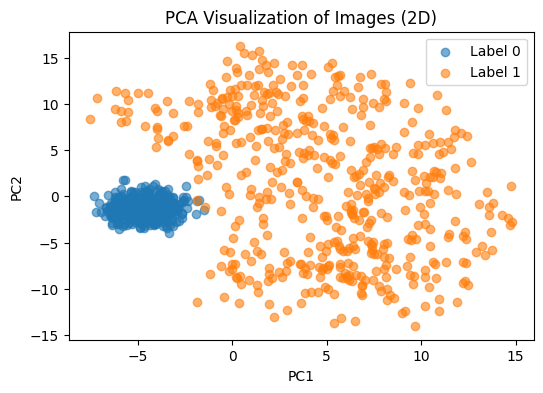

In [6]:
label_mapping = {0: "Label 0", 1: "Label 1"}

plot_pca_2d(images, labels, label_mapping)

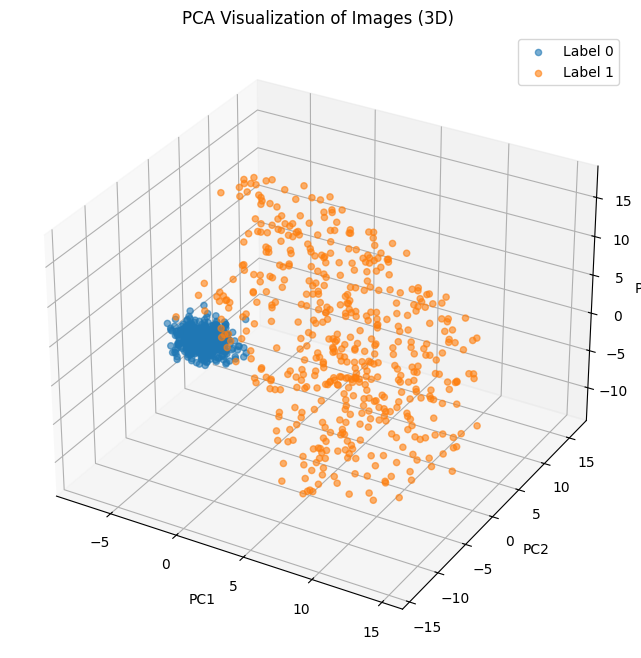

In [7]:
plot_pca_3d(images, labels, label_mapping)

### Pixel-Label Correlation plots

We try two different methods to explore pixel–label relationships and observe that both yield similar patterns in the resulting maps.

1. **Difference Map**:

- We calculate the average image for labels 0 and 1, then deduct the average from the label. This shows the areas where label 1 photos are generally darker (negative/blue) or brighter (positive/red) than label 0 images.

2. **Pixel-wise Correlation**:

- We calculate the Pearson correlation coefficient between the label (0 or 1) and the intensity of each pixel. This indicates the degree to which the brightness of each pixel is linked to either label 0 or label 1.

**Overall Inference:**
The primary characteristic that sets the two labels apart is that the centre region is brighter for label 1, while the surrounding ring is more typical of label 0. This is confirmed by both the difference map and the pixel-wise correlation map.


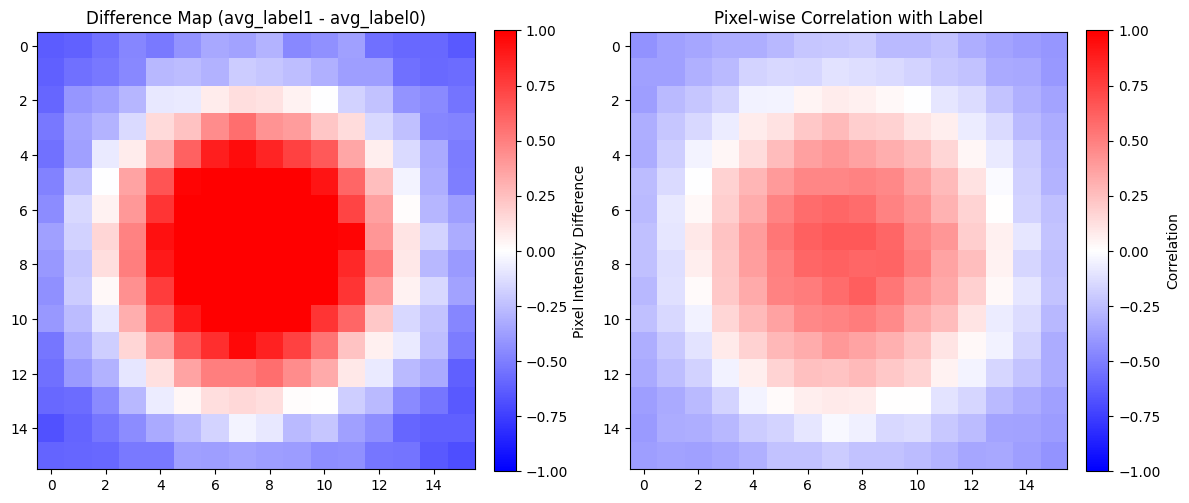

In [8]:
plot_pixel_label_patterns(images, labels)

Another way to intuitively visualize this is by taking 5 images and literally squashing them together into one. We see again this large `vignette-like` region in the center


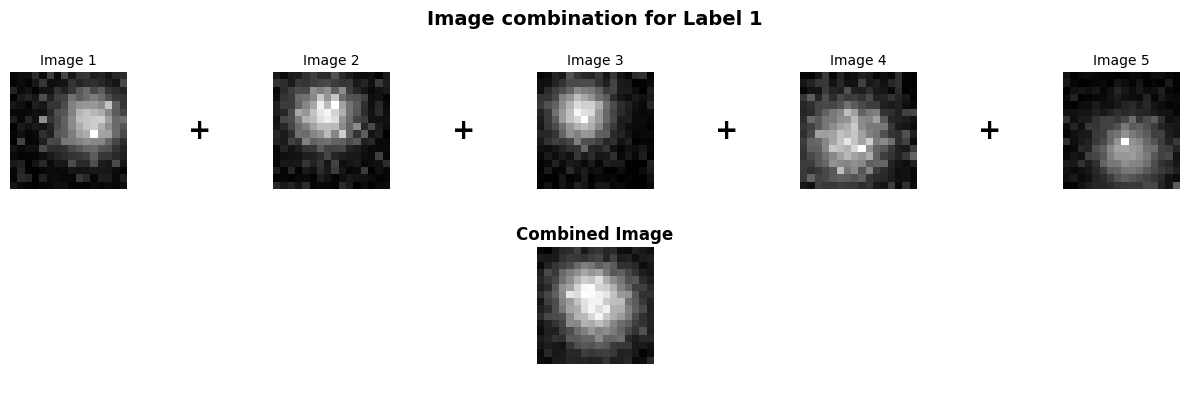

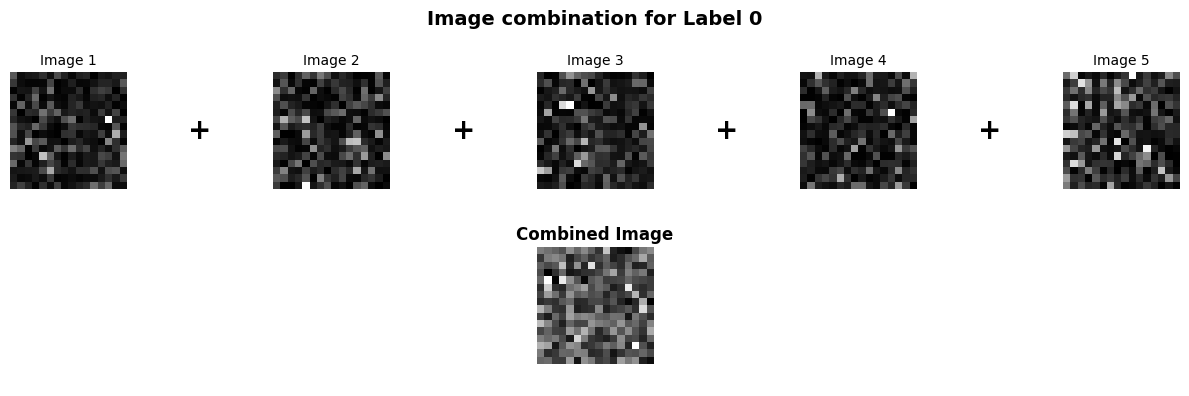

In [9]:
plot_combined_image(images, labels, label_target=1)
plot_combined_image(images, labels, label_target=0)

## Model Loading

On loading the model, we see:

- Two layers with no trainable params (frozen)
- The input layer accepts a _16x16_ Image
- There is a `tf.keras.Lambda` layer, which implies it was a custom function layer which performed **_some_** operation / transformation to the input and gives an output. We have no idea what transformation it applies to the data, but we can check the outputs once.


In [10]:
given_model_path = "./model/"

loaded_model = tf.keras.models.load_model(given_model_path)

print(loaded_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 16)]          0         
                                                                 
 lambda (Lambda)             (None,)                   0         
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


### Running Predictions with the Loaded Model

- The model outputs are all over the place! We have a `mean` value of `268` in this output set. 
- This looks more like a **regression output** than a **classification output**. 
- Let's explore and try to make some changes to this distribution to evaluate the performance of the given model in **classification task** to tell apart the images.

In [11]:
raw_predictions = loaded_model.predict(dataset)
print("Shape of raw predictions:", raw_predictions.shape)

# Print the first 100 predictions
print(raw_predictions[:50], "...")

32/32 [==============================] - 0s 2ms/step
Shape of raw predictions: (1000,)
[244.7044  246.41002 266.4576  287.88644 289.0215  273.17194 278.84222
 281.30768 251.87642 282.83255 265.2982  229.74344 270.4944  276.6785
 260.57513 279.44455 284.62006 273.82898 273.59448 286.1523  280.70038
 210.42487 278.46628 277.4919  248.96593 236.66214 284.1313  275.8073
 277.67722 246.26392 280.5799  291.74368 279.1282  290.51788 285.2177
 285.24307 278.05783 257.39532 248.36151 253.5977  296.36356 268.19556
 252.11034 276.4406  281.2348  281.69077 222.34637 241.48547 281.73138
 264.4213 ] ...


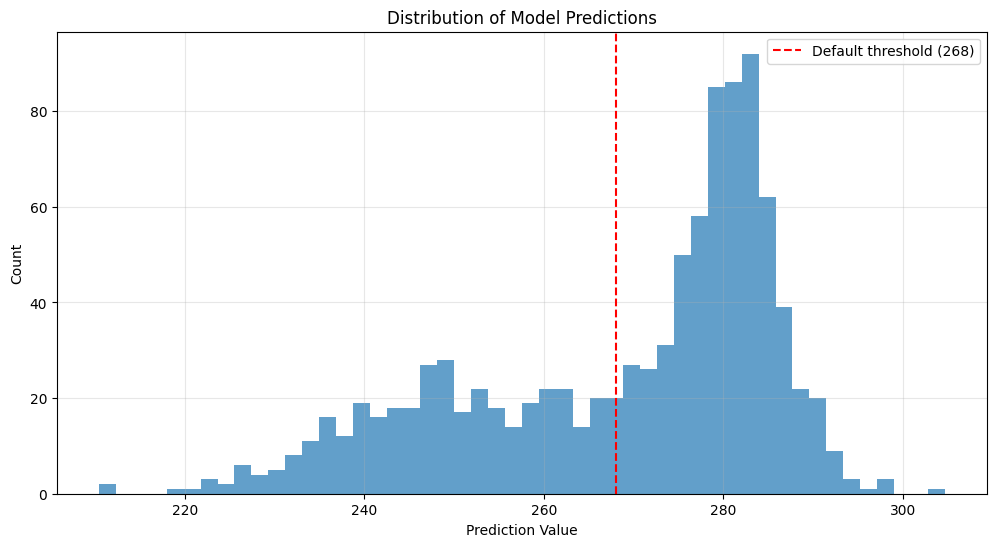

In [12]:
# Let say the threshold is just the mean value value for these predictions
plot_model_prediction_histogram(raw_predictions, threshold=int(raw_predictions.mean()))

Let's scale the model output distribution from 0-1. This will simply shift the distribution to be in a range where metrics like ROC, AUC make sense

[0.36365297 0.38174686 0.59442085 0.82174766 0.833789   0.6656495
 0.7258025  0.7519571  0.43973693 0.76813364 0.58212113 0.20494021
 0.63724476 0.7028487  0.5320169  0.7321922  0.7870963  0.6726197
 0.67013204 0.8033512  0.74551463 0.         0.7218143  0.71147776
 0.4088611  0.27833694 0.78191125 0.69360673 0.7134435  0.38019696
 0.74423647 0.862667   0.72883624 0.84966314 0.7934365  0.7937056
 0.71748126 0.49828398 0.4024492  0.45799708 0.9116767  0.61285776
 0.44221842 0.7003251  0.751184   0.7560211  0.1264688  0.32950506
 0.75645196 0.5728187 ] ...


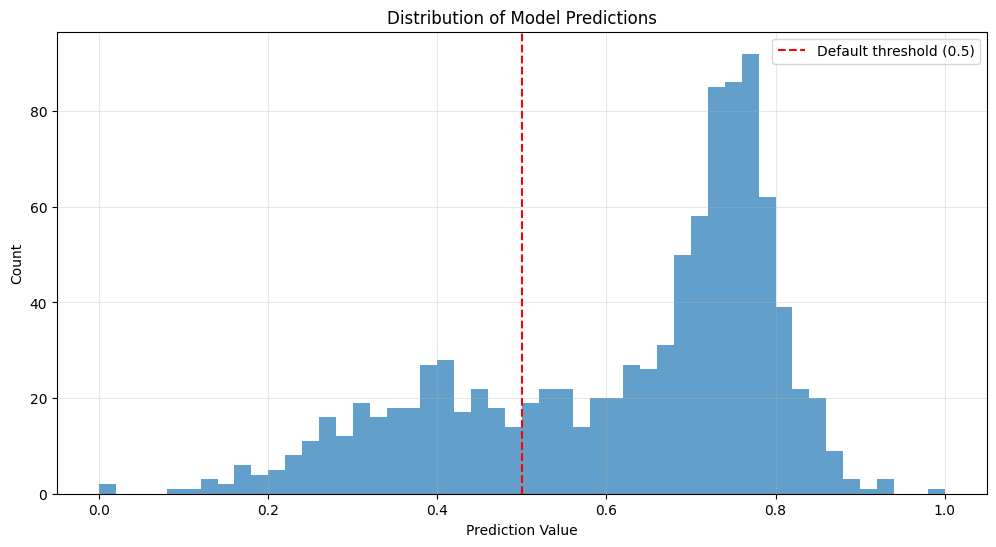

In [13]:
min_val = np.min(raw_predictions)
max_val = np.max(raw_predictions)

scaled_predictions = (raw_predictions - min_val) / (max_val - min_val)

print(scaled_predictions[:50], "...")

plot_model_prediction_histogram(scaled_predictions, threshold=0.5)

### Finding Optimal Threshold for provided model

Let's run a statistical test to evaluate the best threshold for using this model. As we have a balanced dataset, we can utilize Youden's J metric for the evaluation of the best threshold.

**Steps:**

1. Compute the ROC curve. This gives us a set of possible thresholds, the False Positive Rate (FPR), and the True Positive Rate (TPR).
2. Choose a threshold that maximizes the value of Youden J Statistic: $J = TPR - FPR$


In [14]:
optimal_threshold = find_optimal_threshold(labels,scaled_predictions)
print()
optimal_threshold_raw = find_optimal_threshold(labels,raw_predictions)

Computing ROC curve...
Calculating Youden's J statistic...
Optimal threshold based on Youden's J: 0.6750

Computing ROC curve...
Calculating Youden's J statistic...
Optimal threshold based on Youden's J: 274.0519


## Running Evaluations

In [15]:
predicted_classes = (scaled_predictions >= optimal_threshold).astype(int)
predicted_classes[:50]

array([0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0])

- The model correctly classifies about 92.1% of all instances, a strong overall result.
- For `Label 0`: We have higher Precision compared to Recall
- For `Label 1`: We have higher Recall compared to Precision


### Classification Report

In [16]:
print("\nAccuracy:")
accuracy = accuracy_score(labels, predicted_classes)
print(accuracy)

print("\nClassification Report:")
pd.DataFrame(classification_report(labels, predicted_classes, output_dict=True))


Accuracy:
0.921

Classification Report:


,0,1,accuracy,macro avg,weighted avg
precision,0.960613,0.887661,0.921,0.924137,0.924137
recall,0.878000,0.964000,0.921,0.921000,0.921000
f1-score,0.917450,0.924257,0.921,0.920854,0.920854
support,500.000000,500.000000,0.921,1000.000000,1000.000000


- The ROC curve shows a high area under the curve, indicating that the model is good at ranking positive examples higher than negative examples overall. This is why we see `Label 0` misclassified as `Label 1` often.
- The average precision (AP) of ~0.86 suggests that the model has high precision across different recall levels.


### Precision-Recall, ROC Curves


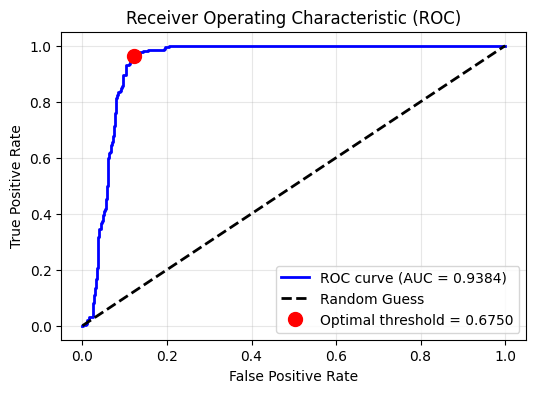

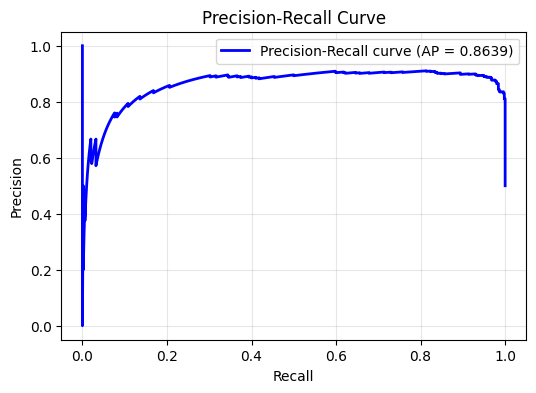

In [17]:
plot_roc_curve(labels, scaled_predictions, optimal_threshold)
plot_precision_recall_curve(labels, scaled_predictions)

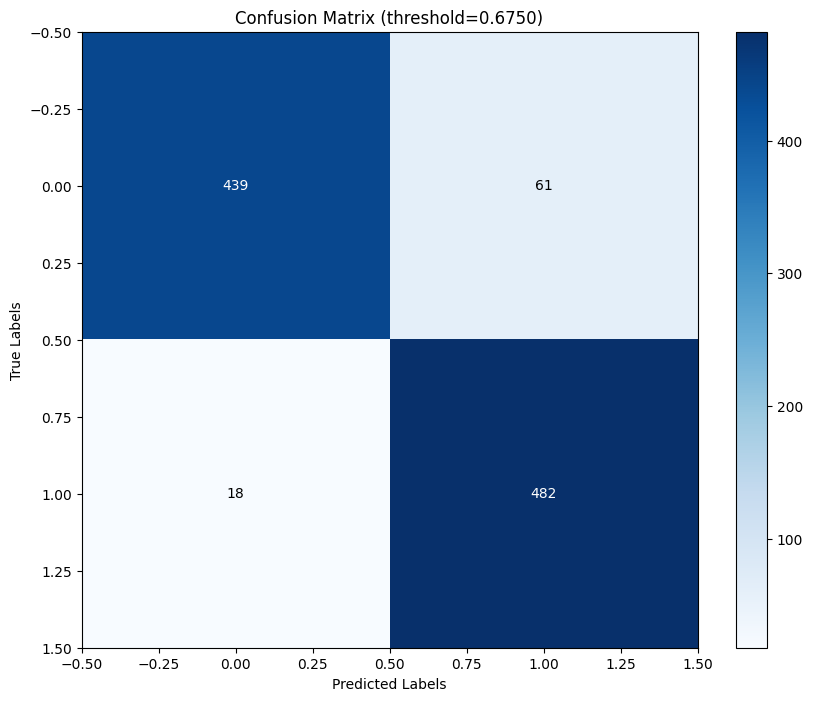

In [18]:
plot_confusion_matrix(labels, predicted_classes, optimal_threshold)

## Figuring out what is in the `Lambda`

### Hypothesis: Lambda layer simples computes a sum over the input kernel: `Lambda(lambda x: x.sum())`


By observing how the _False Positive_, _True Positives_, _True Negative_ and _False Positives_ **actually look like** side-by-side with the thresholds, we understand the behavior of the mode.

### Verifying hypothesis by plotting Model vs hypothesis Outputs


The `compare_sum_model_results` function takes `500` image inputs and `500` random `16x16` samples and passed it through:

1. The loaded model
2. The summation kernel

We Then find the absolute difference between the two and find the outputs to be similar as to 5 digits of precision. Here is a comparison plot to summarize the same.


32/32 [==============================] - 0s 293us/step


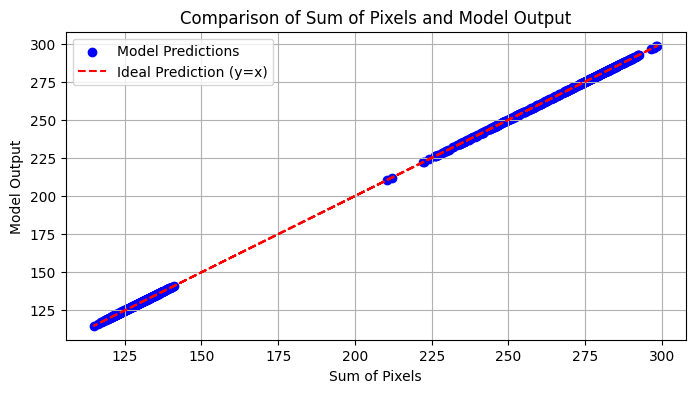

,Input Image,Sum of Pixels,Model Output,Difference (Sum - Model)
0,Random Image #1,129.995467,129.995468,0.000001
1,Random Image #2,132.741279,132.741272,0.000007
2,Random Image #3,132.846353,132.846344,0.000009
3,Random Image #4,125.705035,125.705032,0.000003
4,Random Image #5,128.123202,128.123199,0.000003
...,...,...,...,...
995,Dataset Image #496,257.933672,257.933685,0.000013
996,Dataset Image #497,278.322970,278.322968,0.000002
997,Dataset Image #498,235.434212,235.434204,0.000008
998,Dataset Image #499,269.003902,269.003906,0.000004


In [19]:
df = compare_sum_model_results(loaded_model, images, 500)
plot_sum_vs_model_output_plots(df)
df

### Explaining Model Outputs

- `Label 1` images tend to have **higher** overall pixel intensity than `Label 0` images due to a large, bright, concentrated circle in the center *(seen in #4, #8, #13)*.

- This explains why a simple model that sums input intensities performs well for this type of task.

- Many `Label 0` images are correctly classified since they lack a bright, widespread region *(seen in #3, #9, #12, #19, #20, #24)*.

- When a `Label 0` image has a widely distributed spread of bright pixels, **misclassification** occurs as the overall summed intensity surpasses the classification threshold *(seen in #1, #2, #5, #15, #16, #17, #22, #25)*.

- Similarly, in **false negative** cases where `Label 1` is incorrectly classified, we observe dark spots surrounding the bright concentric ring. These pixels reduce the overall intensity, pushing it below the classification threshold *(seen in #6, #7, #10, #11, #14, #18, #21, #23)*.



Now that we know the underlying kernel. We can understand why certain predictions are what they are.


Optimal Scaled Threshold 0.67498493
Optimal Raw Threshold 274.05194


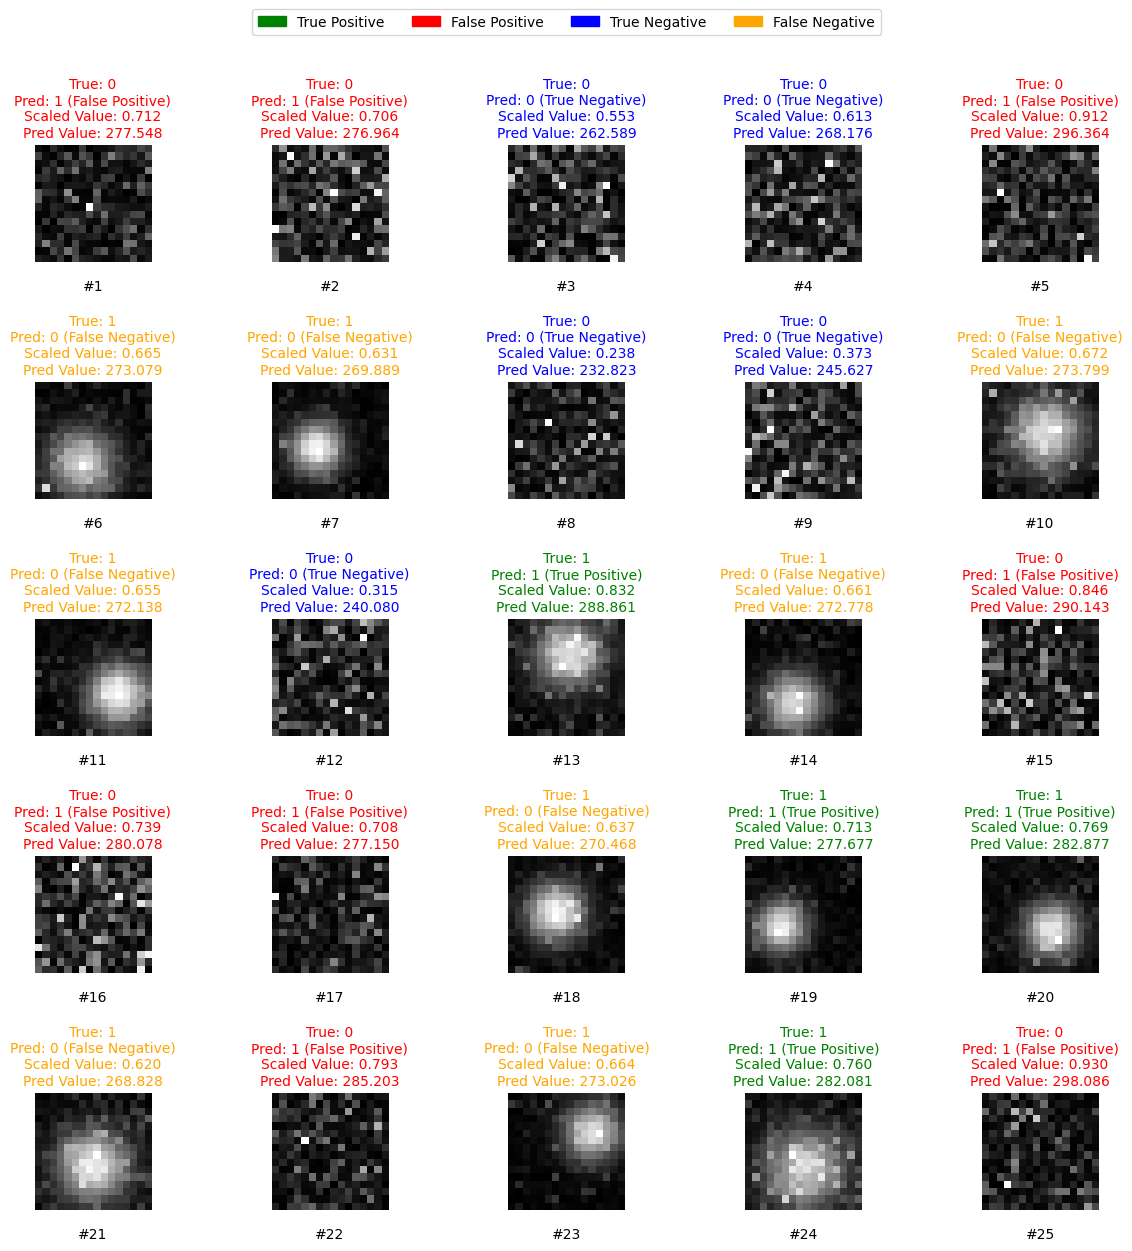

In [26]:
print("Optimal Scaled Threshold", optimal_threshold)
print("Optimal Raw Threshold", optimal_threshold_raw)

plot_sample_predictions(
    images, labels, scaled_predictions, raw_predictions, threshold=optimal_threshold
)